In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Alexander\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# fix a random seed
np.random.seed(7)

# generate data
data = pd.DataFrame({
    "Frank_Sinatras_age": np.arange(0, 82),
    "Level_of_subjective_goodness_that_year": np.concatenate([
        np.random.poisson(10.0, 36),
        np.random.poisson(1.0, 46),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "Level_of_subjective_goodness_that_year"] = np.nan

In [3]:
data.head()

,Frank_Sinatras_age,Level_of_subjective_goodness_that_year
0,0,9.0
1,1,10.0
2,2,8.0
3,3,9.0
4,4,8.0


In [4]:
data.loc[(17,21,35),]

,Frank_Sinatras_age,Level_of_subjective_goodness_that_year
17,17,11.0
21,21,11.0
35,35,9.0


In [5]:
# plot the generated data
toyplot.scatterplot(
    data.Frank_Sinatras_age,
    data.Level_of_subjective_goodness_that_year, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="age", 
    ylabel="goodness",
);

0 25 50 75 age 0 5 10 15 goodness

In [6]:
with pm.Model() as goodness_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.Frank_Sinatras_age.min(), 
        upper=data.Frank_Sinatras_age.max(), 
        testval=40)

    # Priors for pre- and post-switch rates
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.Frank_Sinatras_age, early_rate, late_rate)

    goodness = pm.Poisson('goodness', rate, observed=data.Level_of_subjective_goodness_that_year)

In [7]:
with goodness_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to goodness_missing
100%|██████████| 10500/10500 [00:57<00:00, 181.16it/s]


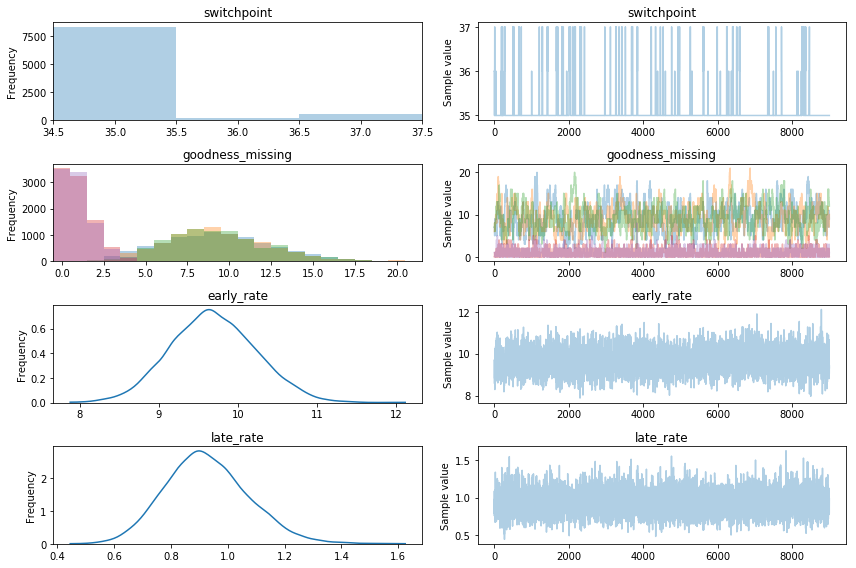

In [8]:
pm.traceplot(trace[1000:]);

In [9]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  35.135           0.481            0.018            [35.000, 37.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  35.000         35.000         35.000         35.000         37.000


goodness_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.375            3.156            0.215            [3.000, 15.000]
  9.324            3.052            0.214            [4.000, 15.000]
  9.271            2.978            0.209            [4.000, 15.000]
  0.925            0.959            0.033            [0.000, 3.000]
  0.940            0.991            0.037            [0.000, 3.000]

  Posterior quantiles:
  2.5         

The model predicted the switchpoint accurately; it detected an mean age of 35.135 as the time at which Frank Sinatra apparently stopped having good years. The true switchpoint of 36 was within the 95% HPD interval.

Early and late rate values matched the input poisson loc fairly well, predicted 9.682 and 0.927 for true 10 and 1 respectively. Both true values were within the 95% HPD interval and both means were slightly below the true values.

The sampler took about a minute to run. I did not encounter any problems running the model.


I also previously ran the model using 35 as an input switchpoint. Curiously, after running several times, the model consistently predicted a mean of only 34 with an HPD interval so small that the decimal place showed 34.000 on both ends of the interval. However, the early and late rates were predicted as above.


https://genius.com/Frank-sinatra-it-was-a-very-good-year-lyrics